In [1]:
import matplotlib.pyplot as plt
import torch, gym, numpy as np
from tqdm import tqdm
from data_processing.neural_networks.DEEP_RL_Deep_Reinfocement_Learning.DEEP_RL_funcs import env_info, policy, value
# from torch.autograd.functional import jacobian
# from torch.autograd import grad
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from IPython.display import clear_output
clear_output()
def update_model_params(model, flat_params):
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        #p.data.copy_(flat_params[offset:offset+numel].view_as(p))
        p.data += flat_params[offset:offset+numel].view_as(p)
        offset += numel

#https://studywolf.wordpress.com/2018/06/20/natural-policy-gradient-in-tensorflow/ did not help. switched to .inv(), not even .pinv(hermitian)
# U, S, Vh = torch.linalg.svd(FIM, full_matrices=False)
# atol = torch.max(S) * 1e-6
# S_inv = torch.diag(1.0 / S)
# S_inv = torch.where(S < atol, 0, S_inv)
# F_inv = Vh.T @ S_inv @ U.T

I need 
$$\boxed{\vec{g} =\nabla_{\theta} J(\pi_{\theta}) =  \frac{1}{|D|} \sum_{\tau \in D}R(\tau)\cdot\sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t) }$$
Using to-go rewards with a baseline thats trained value function:
$$R(\tau) = \sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1}) -b(s_t)$$
For weight update 
$$\theta_{t+1} = \theta_t + \sqrt{\frac{2\epsilon}{\vec{g}^T {F^{-1}} \vec{g}}} F^{-1}\vec{g}$$
we need Fisher information matrix.
$$F = \mathbb{E}\bigg[\nabla_\theta \log \pi(x; \theta) \ \nabla_\theta \log \pi(x; \theta)^T\bigg] = \frac{1}{T} \sum_{t = 1}^T \nabla_\theta \log \pi_\theta(a_t|s_t) \ \nabla_\theta \log \pi_\theta(a_t|s_t)^T$$

This means we will have to get gradients of log-probs.

Inverse is tricky. resource https://studywolf.wordpress.com/2018/06/20/natural-policy-gradient-in-tensorflow/ had problems with FIM 'small eigenvalues'. To recite ChatGPT 4o, small FIM eigenvectors imply that there are directions in parameter space where there is no information. Upon inversion vectors pointing in these directions are unnaturally boosted. 50% dont know what it means.. xd

So instead of filtering SVD inversion, we can do Tikhonov regularization or ridge regularization, by boosting matrices diagonal to enforce positive-definiteness, and perform regular inversion.

In [18]:
env_CP      = env_info('CartPole-v1',device=device)
num_obs     = env_CP.env.observation_space.shape[0]
num_acts    = env_CP.env.action_space.n
progress    = []
progress_std= []

env_CP_policy   = policy(   num_obs, num_acts   , [32])
env_CP_policy.optimizer = None
env_CP_value    = value(    num_obs, 1          , [32], lr = 0.1)
env_CP_policy.to(device)
env_CP_value.to(device)

In [19]:
batch_size  = 1000
tq_iter     = tqdm(range(50))
eps         = 0.001
std_steps, avg_steps = 0,0
tq_prms     = {'std_steps':std_steps,'avg_steps':avg_steps,'evals':env_CP.env_iters}
mod_num_prms = sum(p.numel() for p in env_CP_policy.mlp.parameters())
reward_cap  = 300
advantage   = 'r2g'
#print(mod_num_prms)
for _ in tq_iter:
    # GATHER TRAJECTORIES
    batch_times = env_CP.play_batch(env_CP_policy,batch_size,reward_cap,advantage,(tq_iter,tq_prms))

    # fit state value function
    env_CP_value.train(env_CP.batch_states, env_CP.batch_rewards, n_iters=10)
    # prep log probs
    log_probs = env_CP_policy.log_prob(env_CP.batch_states, env_CP.batch_actions)
    #print(log_probs.max().item())
    b_s       = env_CP_value.get_value(env_CP.batch_states)
    # Compute gradients
    grads = torch.zeros(size = (len(log_probs),mod_num_prms), device=device, dtype = env_CP_policy.dtype )
    for i in range(len(log_probs)):
        g = torch.autograd.grad(log_probs[i], env_CP_policy.mlp.parameters(), retain_graph=True)
        grads[i] = torch.cat([p.view(-1) for p in g])  # flatten and concat all weights in 1D

    with torch.no_grad():
        # CALCULATE FISHER INFORMATION MATRIX
        outers  = grads.unsqueeze(-1) * grads.unsqueeze(-2)  # batched outer product via broadcasting (T,N,1) * (T,1,N)
        FIM     = outers.mean(dim=0)                         # empirical expectation
        FIM     += 0.001 * torch.eye(mod_num_prms, device=device)   # regularization/boost diagonal
        F_inv=torch.linalg.inv(FIM)# , hermitian=True)
        # CALCULATE GRADIENT
        g = grads*(env_CP.batch_rewards.reshape(-1,1) - b_s)
        g = g.mean(dim = 0) # gradient 
        #print(grads.max().item(), grads.min().item())
        # COMPLETE UPDATE 
        d = F_inv @ g
        alpha0 = 2*eps/(torch.dot(g, d)+ 0.00001)
        #print(alpha0.min().item())
        assert alpha0 >0, 'sqrt of negative number'
        alpha = torch.sqrt(alpha0)
        #alpha = 0.01
        #print(torch.linalg.norm(d).item())
        #with torch.no_grad():
        update_model_params(env_CP_policy.mlp, alpha * d)

        std_steps, avg_steps = torch.std_mean(torch.as_tensor(batch_times).to(float))
        std_steps,avg_steps = std_steps.item(), avg_steps.item()
        tq_prms = {'std_steps':std_steps,'avg_steps':avg_steps,'evals':env_CP.env_iters, 'alpha':alpha.item()}
        tq_iter.set_postfix(**tq_prms)
        #print(f'{avg_steps = :0.2f}, {std_steps = :0.2f}')
        progress.append(avg_steps)
        progress_std.append(std_steps)

  0%|          | 0/50 [00:00<?, ?it/s, avg_steps=0, batch_size=0, evals=0, std_steps=0]

100%|██████████| 50/50 [04:41<00:00,  5.63s/it, alpha=0.00565, avg_steps=251, evals=430, std_steps=98]                  


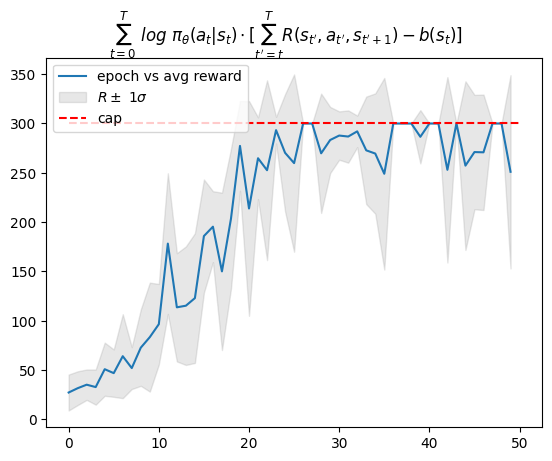

In [21]:
x = torch.arange(len(progress))
y1 = torch.tensor(progress)
y2 = torch.tensor(progress_std)
plt.plot(x,y1, label='epoch vs avg reward')    ;
plt.fill_between(x, y1 - y2, y1 + y2, color='#888888', alpha=0.2, label='$R\pm$ 1$\sigma$')
plt.hlines(reward_cap, 0, len(progress), linestyles='--', label='cap', colors= 'r')
plt.legend()
plt.suptitle(r'$\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot [\sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1}) -b(s_t)]$');

c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


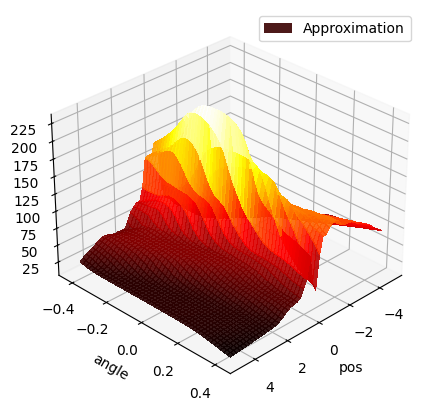

In [22]:
with torch.no_grad():
  x = torch.linspace(env_CP.env.observation_space.low[0], env_CP.env.observation_space.high[0], 50).to(device)
  y = torch.linspace(env_CP.env.observation_space.low[2], env_CP.env.observation_space.high[2], 50).to(device)
  z = torch.zeros([len(x), len(y)])
  for i in range(len(x)):
    for j in range(len(y)):
      z[i,j] =  env_CP_value.get_value(torch.Tensor([x[i],0,y[j],0]).to(float).to(device))[0].cpu().item()
    
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(1, 1, 1, projection='3d',computed_zorder=False)
  X, Y = torch.meshgrid(x.cpu(), y.cpu())
  surf = ax.plot_surface(X.numpy(), Y.numpy(), z, cmap=plt.get_cmap('hot'), linewidth=1.5, antialiased=False, alpha = 0.9, label='Approximation')
  #Z = target_fn(X,Y).reshape(res,res)
  #ax.plot_wireframe(X.numpy(), Y.numpy(), Z.numpy(), rstride=10, cstride=10, linewidth = 0.7, label='True surface')#, zorder = 100)
  ax.view_init(elev=30., azim=45)
  ax.set_xlabel('pos')
  ax.set_ylabel('angle')
  plt.legend()
  plt.show()